(ref:sec:adiabatic-pipe-flow)=
# Adiabatic Pipe Flow

In this section we will have a look at an adiabatic pipe with pressure losses ocurring. With the first law of
thermodynamics we cannot see a change in energy, exergy analysis can reveal the thermodynamic losses.

## Introduction

Consider a well insulated pipeline transporting steam as shown in the figure below.

```{figure} /figures/Pipe.svg
---
name: pipeline-flowsheet
---
Abstract model of the well insulated steam pipeline.
```

Measurement data are obtained at the inlet and the outlet of the pipeline:

| Parameter | Location | Value | Unit |
|:--------- |:-------- | -----:| ---- |
| Temperature | Inlet | 195 | °C |
| Temperature |  | 184.4 | °C |
| Pressure | Inlet | 10 | bar |
|  | Outlet | 6 | bar |
| Mass flow | Inlet | 1.2 | kg/s |

First, we can set up the energy balance equation of the thermodynamic open system, where the work $\dot W$ and heat
$\dot Q$ transferred change the enthalpy $h$ of a mass flow $\dot m$ from a state 1 to a different state 2:

```{math}
    :label: eq:pipe-flow-energy-balance
    \dot W + \dot Q = \dot m \cdot \left(h_2 - h_1\right)
```

Since a pipe does not transfer work to the fluid, work transferred can be considered equal to zero. Therefore the 
specific heat transferred can be calculated by the change of enthalpy. Since the pipeline is well insulated, the value
should be rather small.

```{math}
    :label: eq:pipe-flow-energy-balance-simplified
    \frac{\dot Q}{\dot m} = h_2 - h_1\\
```

To do that computationally, we first import the `PropsSI` function from `CoolProp` and then insert the values from the
table above.

In [285]:
from CoolProp.CoolProp import PropsSI as PSI


fluid = "water"

p_in = 10 * 1e5
T_in = 195 + 273.15
h_in = PSI("H", "P", p_in, "T", T_in, fluid)

p_out = 6 * 1e5
T_out = 184.4 + 273.15
h_out = PSI("H", "P", p_out, "T", T_out, fluid)

q = h_out - h_in
q

-32.01454686373472

````{attention}
As we expected the specific heat transferred is very low. Therefore we will make an assumption, that the pipeline can be
considered adiabatic for further calculations. If transferred work and heat are both zero, the change in enthalpy will
therefore be zero as well:

```{math}
    h_2 = h_1
```
````

We can also double check this, by calculating the outlet temperature at the measured outlet pressure and with the
assumption of non-changing enthalpy. Note that it is only slighty different:

In [286]:
h_out = h_in
PSI("T", "P", p_out, "H", h_out, fluid) - 273.15

184.4142164685411

We have seen, that no energy has been transferred from the pipe to the ambient. Does that mean, we can revert the 
process? Obviously, that does not seem natural, as you cannot change the pressure of the fluid at the outlet back to the
inlet pressure without adding any energy. That means, while we have not lost any energy to the ambient, the energy must
have become less valuable.

## Exergy Analysis

In this chapter, we will learn, how the described change in quality of energy can be made visible using Second Law
analysis. To do that, we calculate the exergy of the fluid at the inlet and at the outlet of the pipe. First, we define
a function, that follows the definition of phyiscal exergy in eq. {eq}`physical-exergy-total` without splitting physical
exergy into mechanical and thermal share. Chemical exergy can be ignored in this application, since no chemical reaction
processes take place.

The function `calc_physical_exergy` will take pressure and enthalpy of a fluid and calculate the thermal and the
mechanical part of the physical exergy.

In [287]:
def calc_physical_exergy(p, h, p0, T0, fluid):
    r"""Calculate specific physical exergy."""
    s = PSI("S", "P", p, "H", h, fluid)    
    h0 = PSI("H", "P", p0, "T", T0, fluid)
    s0 = PSI("S", "P", p0, "T", T0, fluid)
    
    ex = (h - h0) - T0 * (s - s0)
    return ex

Then, we can define an (arbitrary) ambient state and calculate the exergy and the inlet and the outlet state.

In [288]:
p0 = 1.01325 * 1e5
T0 = 20 + 273.15
m = 1

ex_in = calc_physical_exergy(p_in, h_in, p0, T0, fluid) * m
ex_in

863747.8363819825

In [289]:
ex_out = calc_physical_exergy(p_out, h_out, p0, T0, fluid) * m
ex_out

797952.1230949757

First, we need to define the exergy fuel (inlet mass flow) and exergy product (outlet mass flow). With that, the exergy
destruction (eq. {eq}`ex-d-k`) and the exergy efficiency (eq. {eq}`ex-eff-k`) are easily found:

In [290]:
exergy_destruction = ex_in - ex_out
exergy_destruction

65795.71328700683

In [291]:
exergy_efficiency = ex_out / ex_in
exergy_efficiency

0.9238253220261504

In [292]:
from myst_nb import glue
glue("exergy_destruction", exergy_destruction, display=False)
glue("exergy_efficiency", exergy_efficiency * 100, display=False)

We see that a total of {glue:text}`exergy_destruction:.0f` J/kg is destroyed, which corresponds to an efficiency of about {glue:text}`exergy_efficiency:.2f` %.

-> Exergy efficiency macht als Begriff hier wenig Sinn
-> Sankey/Grassmann


-> Mit Aufteilung thermisch/mechanisch dann auch nochmal ein Grassmann was zeigt: Nur Exergie vs. aufgeteilte Exergie

## Excercises

With the information from the sections above:

1. Calculate the total exergy destruction and the exergy efficiency of the pipe flow for varying outlet pressures in a
   range from the ambient pressure to the inlet pressure.
2. As a function of the outlet pressure (x-axis) plot the:
   - exergy destruction (y-axis).
   - exergy efficiency (y-axis).
4. Instead of a steam flow consider flow of hot air:
   - Create a plot with exergy destruction and exergy efficiency of both air and water inside the same subplots.
   - Why is the influence of the pressure on the exergy efficiency of the air flow much higher than on the exergy
     efficiency of the steam flow?
5. Create a function that splits the physical exergy in its thermal and mechanical shares.
   - Verify that your function produces the same result as the function defined in the introduction to this section.
   - Create a plot that shows, how thermal and mechanical exergy are affected by the pressure change for steam and for
     air within thespecified pressure range.

### Solution 1 - 2

We can use numpy to create a vector of outlet pressure values and then calculate the outlet exergy vector. The inlet
exergy does not change for all values. Then with matplotlib we can create two subplots sharing the same x-axis (i.e. the
pressure range) and plot the exergy destruction and the exergy efficiency.

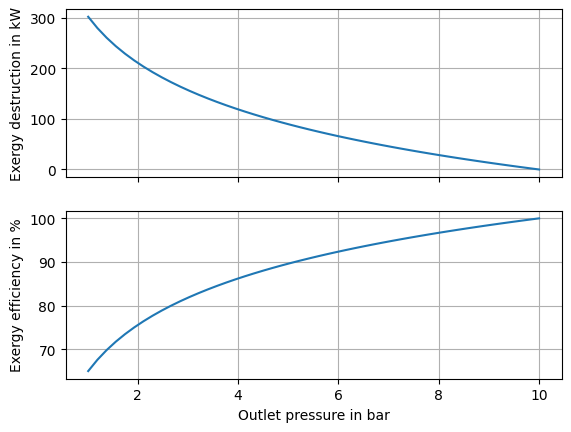

In [293]:
import numpy as np
from matplotlib import pyplot as plt

pressure_range = np.linspace(p0 / 1e5, 10) * 1e5
ex_out = calc_physical_exergy(pressure_range, h_out, p0, T0, fluid) * m
ex_in = calc_physical_exergy(p_in, h_in, p0, T0, fluid) * m


fig, ax = plt.subplots(2, sharex=True)

ax[0].plot(pressure_range / 1e5, (ex_in - ex_out) / 1e3)
ax[1].plot(pressure_range / 1e5, ex_out / ex_in * 100)

ax[0].set_ylabel("Exergy destruction in kW")
ax[1].set_ylabel("Exergy efficiency in %")
ax[1].set_xlabel("Outlet pressure in bar")

_ = [(_.grid(), _.set_axisbelow(True)) for _ in ax]

### Solutions 3

We can build the same setup for the air flow using the defined inlet state. Since the enthalpy at the inlet is not the
same as the enthalpy of water, we need to recalculate that value.

In the plots we plot the air and steam exergy destruction and efficiency into the same subplots and label them for the
legend.

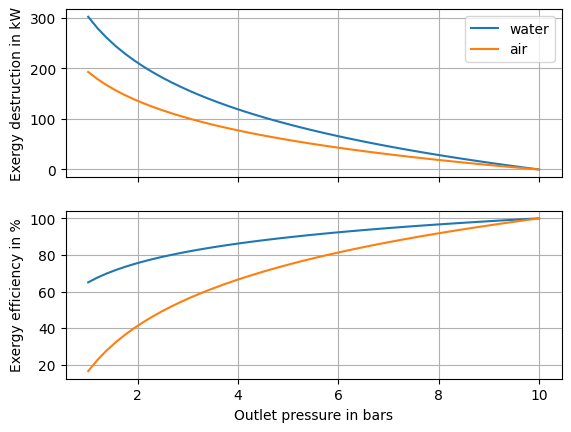

In [294]:
fluid = "air"
h_in_air = PSI("H", "T", T_in, "P", p_in, fluid)
h_out_air = h_in_air

ex_out_air = calc_physical_exergy(pressure_range, h_out_air, p0, T0, fluid)
ex_in_air = calc_physical_exergy(p_in, h_in_air, p0, T0, fluid)


fig, ax = plt.subplots(2, sharex=True)

ax[0].plot(pressure_range / 1e5, (ex_in - ex_out) / 1e3, label="water")
ax[0].plot(pressure_range / 1e5, (ex_in_air - ex_out_air) / 1e3, label="air")

ax[1].plot(pressure_range / 1e5, ex_out / ex_in * 100)
ax[1].plot(pressure_range / 1e5, ex_out_air / ex_in_air * 100)

ax[0].set_ylabel("Exergy destruction in kW")
ax[1].set_ylabel("Exergy efficiency in %")
ax[1].set_xlabel("Outlet pressure in bars")

ax[0].legend()
_ = [(_.grid(), _.set_axisbelow(True)) for _ in ax]

In the first subplot we can see that in the steam flow the exergy destruction is higher by a factor of about 1.5. We
can check the exact ratio with an individual plot. That also shows that the ratio does not change with pressure. The
reason for the sharp decrease of exergy efficiency of the air flow thus cannot be sought here. Instead, we are going to
seek for the explanation when looking at the exergy of the flows "stored" in mechanical and thermal properties of the
fluid.

C:\Users\witt_fa\AppData\Local\Temp\ipykernel_8300\2765609977.py:3: RuntimeWarning: invalid value encountered in divide
  ax.plot(pressure_range / 1e5, (ex_in_air - ex_out_air) / (ex_in - ex_out))


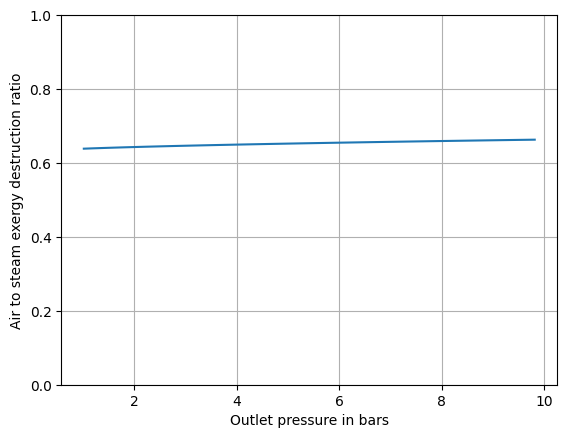

In [295]:
fig, ax = plt.subplots(1)

ax.plot(pressure_range / 1e5, (ex_in_air - ex_out_air) / (ex_in - ex_out))

ax.set_ylim([0, 1])
ax.set_ylabel("Air to steam exergy destruction ratio")
ax.set_xlabel("Outlet pressure in bars")

_ = ax.grid(), ax.set_axisbelow(True)

### Sulution 4

First we define a new function that returns the thermal and the mechanical share of exergy according the the equations
{eq}`thermal-exergy`, {eq}`mechanical-exergy` and {eq}`physical-exergy`. Then we can calculate the share of thermal and
mechanical exergy at the inlet state of the air pipe and validate, if the sum of both shares is equal to the result from
our first implementation of the physical exergy:


In [296]:
def calc_splitted_physical_exergy(p, h, p0, T0, fluid):
    r"""Calculate specific physical exergy according to splitting rule."""
    s = PSI("S", "P", p, "H", h, fluid)
    
    h_T0_p = PSI("H", "P", p, "T", T0, fluid)
    s_T0_p = PSI("S", "P", p, "T", T0, fluid)
    
    ex_therm = (h - h_T0_p) - T0 * (s - s_T0_p)
    
    h0 = PSI("H", "P", p0, "T", T0, fluid)
    s0 = PSI("S", "P", p0, "T", T0, fluid)
    
    ex_mech = (h_T0_p - h0) - T0 * (s_T0_p - s0)
    return ex_therm, ex_mech

ex_T_in_air, ex_M_in_air = calc_splitted_physical_exergy(p_in, h_in_air, p0, T0, "air")
ex_T_in_air + ex_M_in_air == calc_physical_exergy(p_in, h_in_air, p0, T0, "air")

Next, we check the shares for air and steam at the respective inlet state. We can do that with a bar chart.

In [304]:
ex_T_air_ratio = ex_T_in_air / (ex_T_in_air + ex_M_in_air)
ex_M_air_ratio = ex_M_in_air / (ex_T_in_air + ex_M_in_air)

ex_T_in_steam, ex_M_in_steam = calc_splitted_physical_exergy(p_in, h_in, p0, T0, "water")

ex_T_steam_ratio = ex_T_in_steam / (ex_T_in_steam + ex_M_in_steam)
ex_M_steam_ratio = ex_M_in_steam / (ex_T_in_steam + ex_M_in_steam)

0.1672487070203287

In [305]:
fig, ax = plt.subplots(1)

ax.bar([0.9, 1.1, 1.9, 2.1], [ex_T_air_ratio, ex_M_air_ratio, ex_T_steam_ratio, ex_M_steam_ratio])

0.8327512929796713

0.9989579092785752

0.001042090721424985

We can easily see, that the mechanical exergy is the main contributor to the air exergy with about 83.3%. For the steam flow
it is not only reversed, but we see that the exergy stored in the vapour is almost exclusively thermal exergy with a
share of about 99.9%.

## Lessons Learned

- Exergy analysis can be used to detect thermodynamic losses, that are invisible using first law analysis.
- Physical exergy of a mass flow can be splitted into a thermal and a mechanical share.